# Alumno: Oscar Mateos López

# **Ejercicios NLP (primera parte) Para evaluar la primera parte del módulo de PLN se proponen dos ejercicios**
 
Ambos ejercicios utilizan el corpus de críticas de cine "mundocine". 

Estas críticas están almacenadas en archivos XML en un formato que ya se ha visto el el notebook NLP_07.

In [1]:
import os
import zipfile
import numpy as np
import pandas as pd
from pprint import pprint
import warnings
#from xml.dom.minidom import parseString
from bs4 import BeautifulSoup

# Normalizacion y limpieza
import re
from unicodedata import normalize
from nltk.corpus import stopwords

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
warnings.filterwarnings('ignore')
 
# spacy para lematizar
import spacy
 
# herramientas de dibujado
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Me descargo el fichero de mi drive a traves de un enlace compartido (tenia problemas al subirlo al Colab a mano)
!gdown --id 1uWcXDDZirXxJkjxM04Pntf4XoNDc1rvu

Downloading...
From: https://drive.google.com/uc?id=1uWcXDDZirXxJkjxM04Pntf4XoNDc1rvu
To: C:\Users\omate\Downloads\NLP E2\criticas.zip

0.00B [00:00, ?B/s]
524kB [00:00, 4.89MB/s]
1.57MB [00:00, 6.57MB/s]
3.15MB [00:00, 9.08MB/s]
4.72MB [00:00, 10.5MB/s]
6.29MB [00:00, 11.6MB/s]
6.73MB [00:00, 10.1MB/s]


In [3]:
with zipfile.ZipFile("criticas.zip","r") as zip_ref:
    zip_ref.extractall(".")

In [4]:
# Contamos número de criticas total en train
!ls criticas/train/*.xml | wc -l

2714


In [5]:
# Contamos número de criticas total en test
!ls criticas/test/*.xml | wc -l

1164


# **Ejercicio 2: topic modeling**
Une ambos conjuntos de críticas en un directorio común y entrena un modelo de topic modeling sobre este corpus. Determina el número más adecuado de temas (prueba el barrido entre 5 y 15 solamente). 

Haz un pequeño análisis de las temáticas:
- Nº de documentos con cada temática como principal.
- Documento más representantivo de cada temática.
- Principales términos que determinan cada temática.


# Descripción del proceso

El proceso es un pipeline manual (no se ha llegado a integrar en un pipeline real, pero podría automatizarse totalmente) donde se realizan los siguientes pasos:

Preparación del corpus
 - Generación del directorio *topic_corpus*
 - Función para procesar e interpretar los XMLs por Streaming de ficheros
 - Preparacion del conjunto de Stop-Words
 - Clase de pre-procesado simple, limpieza del texto y tokenizado de textos
 - Colocaciones: Creamos bigramas y trigramas
 - Lematizado y filtrado de POS-Tags
 - Ranking y poda de palabras más frecuentes del corpus, expansion de las Stop-words con palabras del ámbito cinematográfico
 - Creamos el diccionario y el corpus para Topic Modeling
 
Creación del modelo LDA
 - Generación y visualización de un modelo inicial
 - Optimización del Diccionario y del Corpus: Búsqueda de los parámetros de filtrado
 - Generación y visualización de un modelo con el nuevo corpus
 - Selección del número de temas, barrido entre 5 y 15 temáticas
 - Generacion de los modelos con el mejor número de temas y aplicaciones prácticas
     - Principales términos que determinan cada temática, mediante la visualización de las temáticas
     - Determinar el tema dominante en cada documento 
     - Determinar el documento más representativo de cada temática
     - Distribución de temas entre documentos (Nº de documentos con cada temática como principal)


<img src="https://miro.medium.com/max/700/1*_Fc9iOoKx0kgAmrjEEFH2g.png">

Fuente imagen: https://medium.com/@armandj.olivares/topic-modeling-on-spanish-text-f7a5e998fb90

## Preparación del corpus

In [6]:
# Operaciones para obtener el directorio 'criticas/topic_corpus' con el contenido de train y test
%mkdir criticas\topic_corpus

In [7]:
!ls criticas

test
topic_corpus
train


In [8]:
!move criticas\test\*.xml criticas\topic_corpus >nul
!move criticas\train\*.xml criticas\topic_corpus >nul

In [103]:
# Contamos número de criticas total en train
!ls criticas/topic_corpus/*.xml | wc -l

3878


In [10]:
!rm -rf criticas\test\
!rm -rf criticas\train\

In [11]:
!ls criticas

topic_corpus


## Función para procesar e interpretar los XMLs por Streaming de ficheros

**Restos de HTML detectados**

Como hay muchos caracteres HTML a los que se les ha limpiado el caracter de apertura '&', analizamos donde se elimina este caracter y se detecta que es en la funcion `parse_folder` que veníamos usando del ejercicio 1 propuesta en clase, donde se elimina este caracter, tras varias pruebas se decide volver a implementar esta funcion de forma mucho más simple y que interprete correctamente las codificaciones de caracteres especiales HTML.

**Se usará el parser xml de BautifulSoup que interpreta el texto HTML correctamente.**

In [12]:
# Funcion para cargar las criticas de cada directorio en modo stream con BeautifulSoup
def parse_folder(path):
    """generator that reads the contents of XML files in a folder
    Returns the <body> of the <review> in each XML file.
    XML files encoded as 'latin-1'"""
    for file in sorted([f for f in os.listdir(path) if f.endswith('.xml')],
                        key=lambda x: int(re.match(r'\d+',x).group())):
        #with open(os.path.join(path, file), encoding='latin-1') as f:
        #   doc=parseString(f.read())
        with open(os.path.join(path, file), encoding='latin-1') as f:
            contents = f.read()
            
            soup = BeautifulSoup(contents, 'xml')

            titulo = soup.review['title']
            rtxt = soup.summary.text
            btxt = soup.body.text  
            rank = int(soup.review['rank'])
 
            #Tramificar puntuaciones
            if (rank >= 1 and rank <= 2):
              rank_rating = "MALA"
            elif (rank == 3):
              rank_rating = "REGULAR"
            elif (rank > 3 and rank <= 5):
              rank_rating = "BUENA"
 
            yield titulo, rtxt, btxt, rank, rank_rating

**Limpieza inicial de los textos: Función para realizar la primera limpieza básica de los textos previa a sacar bi-gramas o tri-gramas**

Limpieza básica para eliminar menciones (@ o #), URLs, emails, saltos de línea, espacios exta... esta normalización suave se realiza previa a la extracción de bigramas y tri-gramas, por lo que aún ni se lematiza ni se filtra mediante POS-tagging o resticciones de longitudes.

También se eliminan acentos y otras puntuaciones diacríticas* mediante normalización canónica y se pasa todo a minúsculas.
Se usarán expresiones regulares.

**Eliminación de diacríticos**

Eliminar todos los diacríticos excepto la ñ:

Todas las marcas diacríticas están en un bloque en el rango U+0300 - U+036F (Combining Diacritical Marks). Y vamos a hacer la excepción para U+0303, la virgulilla (~), pero 
 - sólo si está después de una n (reemplazando otras como una ã) 
 - y sólo si no tiene otros diacríticos (reemplazando cosas raras como ñ͚͡) con un regex donde el primer grupo es el caracter base y los diacríticos están fuera del grupo:

`([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+`

  - `([^n\u0300-\u036f])[\u0300-\u036f]+` un caracter que no es una n ni un diacrítico, seguido de diacríticos, o
  - `(n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+` una `n` que no está seguida por `~` (a menos que esta última esté seguida por otro diacrítico), entonces sí que coincida con todos los diacríticos que le siguen.

Reemplazando por `\1` nos quedamos con la letra sin el diacrítico.

Fuente: https://es.stackoverflow.com/questions/135707/c%C3%B3mo-puedo-reemplazar-las-letras-con-tildes-por-las-mismas-sin-tilde-pero-no-l

In [13]:
# Definimos reglas de limpieza antes de lematizar 
def sanitize_doc(text):
    """Función realiza una primera limpieza-normalización del texto a traves de expresiones regex"""
    text = re.sub(r'@[\w_]+|#[\w_]+|https?://[\w_./]+', '', text) # Elimina menciones y URL, esto sería más para Tweets pero por si hay alguna mención o URL al ser criticas web   
    text = re.sub('\S*@\S*\s?', '', text) # Elimina correos electronicos
    text = re.sub(r'[(\d+)]+', '', text) #Elimina numeros entre parentesis
    text = re.sub(r'\n', '', text) #Elimina saltos de linea
    text = re.sub('\s+', ' ', text) # Elimina espacios en blanco adicionales
    text = re.sub(r'-+', '', text) # Quita guiones para unir palabras compuestas (normalizaría algunos casos, exmujer y ex-mujer, todos a exmujer)
    text = re.sub(r'\.{3}', ' ', text) # Reemplaza puntos suspensivos
    # Esta exp regular se ha incluido "a mano" tras ver que era necesaria para algunos ejemplos
    text = re.sub(r"([\.\?])", r"\1 ", text) # Introduce espacio despues de punto e interrogacion
    # -> NFD (Normalization Form Canonical Decomposition) y eliminar diacríticos
    text = re.sub(r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
                  normalize( "NFD", text), 0, re.I) # Eliminación de diacriticos (acentos y variantes puntuadas de caracteres por su forma simple excepto la 'ñ')
    # -> NFC (Normalization Form Canonical Composition)
    text = normalize( 'NFC', text)

    return text.lower().strip()

## Preparacion del conjunto de Stop-Words

In [14]:
# Como hemos quitado acentos en los docs aqui tambien ya que se ha comprobado que hay terminos acentuados
sanitized_stopwords = [sanitize_doc(w) for w in stopwords.words('spanish')]

# Vemos las 10 primeras...
sanitized_stopwords[:10]

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se']

## Clase de pre-procesado simple, limpieza del texto y tokenizado de textos
Esta es una vieja conocida del Ejercicio 1, se ha mantenido el criterio de imputación de criticas faltantes por su resumen o eliminación de la critica completa si faltan ambos.
También se ha cambiado la llamada a lemmatize_doc por simple_preprocess de Gensim y la función de saneado de texto anterior.

In [15]:
# Se define el iterador como una clase, 
# se diferencia de un simple generator en que se puede reiniciar
class PreprocesaCriticasClass(object):
    """Pre-procesa el corpus de críticas con la función de la librería gensim
    Entrada: directorio de críticas
    Salida: iterador sobre las críticas (como lista de tokens)"""
    def __init__(self, dirname):
        # variable interna de la clase para el dir
        self.dirname = dirname
 
    # Necesario definir metodo __iter__
    # Tuplas de parse_folder: (titulo, rtxt (resumen de la critica), btxt (critica), rank [1-5])
    def __iter__(self):
        for c in parse_folder(self.dirname): # aqui se reinicia cada vez (empieza desde el principio)
          # Usamos mejor el criterio de usar el resumen si este es mayor que la crítica,
          if len(c[1]) > len(c[2]):
            yield [word for word in simple_preprocess(sanitize_doc(c[1])) if word not in sanitized_stopwords]  # Filtramos Stop-Words
          # Y para los casos en los que ambas esten vacías se eliminarían
          elif len(c[2]) == 0:
            continue   # Saltamos la(s) vacía(s)
          else:
            yield [word for word in simple_preprocess(sanitize_doc(c[2])) if word not in sanitized_stopwords] # Filtramos Stop-Words

**Análisis de la limpieza realizada**

In [16]:
# Corpus folder
path = "criticas\\topic_corpus\\"
texto = PreprocesaCriticasClass(path)

In [17]:
# Primera critica ya tokenizada y limpia
for t in texto:
    print(t)
    break

['cada', 'vez', 'gusta', 'menos', 'cine', 'masas', 'peliculas', 'ven', 'mundo', 'parecen', 'cada', 'vez', 'coñazo', 'insufribles', 'siempre', 'prota', 'tonto', 'culo', 'suerte', 'final', 'peli', 'logrado', 'vencer', 'mal', 'convierte', 'listo', 'chorradas', 'hacia', 'comienzo', 'pelicula', 'esfuman', 'arte', 'magia', 'vuelve', 'maduro', 'inteligente', 'peli', 'spielberg', 'mismo', 'huir', 'huir', 'den', 'solo', 'tiro', 'ademas', 'cabron', 'metido', 'par', 'actores', 'echarles', 'comer', 'aparte', 'niña', 'vieja', 'metida', 'cuerpo', 'niña', 'solo', 'verle', 'hablar', 'version', 'original', 'claro', 'darse', 'cuenta', 'grandes', 'freaks', 'cine', 'creeran', 'hace', 'gracia', 'nena', 'habla', 'igual', 'puta', 'madre', 'causa', 'pavor', 'ver', 'cria', 'habla', 'persona', 'madura', 'horroroso', 'niños', 'niños', 'verlos', 'rol', 'asusta', 'luego', 'hijo', 'adolescente', 'cruise', 'subnormal', 'darle', 'bofetadas', 'vea', 'hueso', 'mano', 'fiel', 'reflejo', 'denomina', 'manipulacion', 'mili

### **Colocaciones: Creamos bigramas y trigramas**
Creamos un modelo para las palabras más frecuentes como bigrama para considerar estos tokens juntos en lugar de separados.

In [18]:
#creamos bigramas y trigramas
# es importante usar un iterador que se pueda recorrer varias veces (texto con la clase en vez de funcion que itera)
bigram = gensim.models.Phrases(texto, min_count=10, threshold=100) # higher threshold fewer phrases.
# si no vamos a reentrenar el corpus podemos usar el diccionario de Phraser
#optimizamos una vez entreando
bigram_mod = gensim.models.phrases.Phraser(bigram)

trigram = gensim.models.Phrases(bigram_mod[texto], min_count=10, threshold=100)  
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_trigrams(text):
    '''Devuelve un doc convertido en trigramas según el
    modelo trigram_mod. La entrada tiene que ser una lista
    de de tokens'''
    return trigram_mod[bigram_mod[text]]

Clases *Streamer* de datos para generar el texto convertido en bigramas o bigramas+trigramas a partir de un corpus normalizado:

In [19]:
# Hay q definir clase iterable para q vuelva desde el principio para poder usarlo con LDA por ejemplo
# La entrada debe haber sido normalizada previamente
class TrigramCorpus(object):
    """Pre-procesa un archivo de texto línea a línea
    Entrada: nombre del archivo de texto a procesar (string) NORMALIZADO
    Salida: iterador sobre cada línea normalizado (lista de tokens)"""
    def __init__(self, corpus):
        self.corpus = corpus
 
    def __iter__(self):
        for t in self.corpus:
            yield make_trigrams(t) # devuelve el texto procesado por la funcion de crear trigramas

In [20]:
# Comprobamos con bigramas primer texto
doc1 = next(iter(texto))
re.findall(r'\w+_\w+', str(bigram_mod[doc1]))

['version_original',
 'darse_cuenta',
 'quereis_diga',
 'efectos_especiales',
 'hoy_dia']

Transformamos el corpus de texto con el modelo de Bigramas-Trigramas. Creamos un `generador` para no cargar todo el corpus procesado en memoria.

In [21]:
# Cuando instancio esta clase cada vez q la llamo empieza dsd el inicio
# texto = PreprocesaCriticasClass(path)
textos_trigramas = TrigramCorpus(texto)
textos_trigramas

In [22]:
# Comprobamos bigramas y trigramas
textos = []
for t in textos_trigramas:
    textos.append(t)
    
tokens = [token for texto in textos for token in texto]
print(re.findall(r'\w+_\w+_\w+', str(set(tokens))))

['helena_bonham_carter', 'the_river_king', 'soplo_aire_fresco', 'world_trade_center', 'salvar_soldado_ryan', 'espectadores_seres_humanos', 'proyecto_bruja_blair', 'basada_hechos_reales', 'maldicion_flor_dorada', 'pasar_buen_rato', 'pilar_lopez_ayala', 'buen_sabor_boca', 'of_new_york', 'codigo_da_vinci', 'harry_potter_orden_fenix', 'juan_antonio_bayona', 'segunda_guerra_mundial', 'viento_agita_cebada', 'million_dollar_baby', 'bla_bla_bla', 'pequeña_miss_sunshine', 'james_newton_howard', 'gus_van_sant', 'ii_guerra_mundial', 'lars_von_trier', 'noche_muertos_vivientes', 'sacha_baron_cohen', 'hacia_rutas_salvajes', 'cofre_hombre_muerto', 'paul_thomas_anderson', 'ultimo_rey_escocia', 'deja_buen_sabor', 'podria_haber_sido', 'shaun_of_the_dead', 'juan_carlos_fresnadillo', 'philip_seymour_hoffman', 'alejandro_gonzalez_iñarritu', 'bryce_dallas_howard', 'maldicion_perla_negra', 'gael_garcia_bernal', 'leonardo_di_caprio', 'robert_downey_jr', 'amantes_circulo_polar', 'lost_in_translation', 'tommy_l

## Lematizado y filtrado de POS-Tags

Ahora que hemos comprobado la limpieza y generación de trigramas vamos con el lematizado y filtrado de determinados POS-tags previo a la creacion del Corpus y el Diccionario

In [23]:
# Redefinimos con nuevas reglas de limpieza POS
nlp = spacy.load('es_core_news_md', disable=['parser', 'ner'])

#def lemmatize_doc(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PROPN','ADP']): # conjunciones, verbos aux, preposiciones... no son importantes para el topuic modeling
#def lemmatize_doc(text, allowed_postags=['NOUN', 'ADJ', 'ADV', 'VERB']): # limitamos un poco mas quitando nombres propios
#def lemmatize_doc(text, allowed_postags=['NOUN', 'ADJ', 'PROPN']): # limitamos mas dejando solo nombres, nombres propios y adjetivos
def lemmatize_doc(text, allowed_postags=['NOUN', 'PROPN']): # limitamos mas dejando solo nombres, nombres propios y adjetivos
    """Función que devuelve el lema de una string,
    excluyendo las palabras cuyo POS_TAG no está en la lista"""
    text_out = [t.lemma_.lower() for t in nlp(text)
                if t.pos_ in allowed_postags
                and len(t.lemma_)>3
                and t.lemma_ not in sanitized_stopwords
                and not t.is_stop] # Usamos adicionalmente a los stop-words de nltk los de sapcy
    return text_out

**NOTA A POSTERIORI:** Como se puede apreciar por las lineas de definición de la función comentadas, se ha ido jugando con los POS-tags válidos. Tras cierta investigación y como Martin, F., & Johnson, M. (2015) sugirieron en su paper abajo referenciado, se ha decidido **simplificar el vocabulario quedandonos sólamente con nombres**.

**Función Streamer Lematizadora**

Se construye para ser llamada encima de la de generar trigramas.

In [24]:
# Hay q definir clase iterable para q vuelva desde el principio para poder usarlo con LDA por ejemplo
# La entrada debe haber sido normalizada previamente
class LematizeCorpus(object):
    """Pre-procesa un archivo de texto línea a línea
    Entrada: nombre del objeto TrigramCorpus
    Salida: iterador sobre cada línea lematizado """
    def __init__(self, corpus):
        self.corpus = corpus
 
    def __iter__(self):
        for t in self.corpus: 
            # Lematizamos cada lista de tokens reconvertida a string
            yield lemmatize_doc(str(t))

In [25]:
# Cuando instancio esta clase cada vez q la llamo empieza dsd el inicio
# texto = PreprocesaCriticasClass(path)
textos_lemas_trigramas = LematizeCorpus(TrigramCorpus(textos))
textos_lemas_trigramas

In [26]:
# Primera critica ya lematizada, con bi-trigramas y limpia
for t in textos_lemas_trigramas:
    print(t)
    break

['cine', 'masa', 'pelicula', 'mundo', 'coñazo', 'prota', 'tonto', 'culo', 'suerte', 'peli', 'listo', 'comienzo', 'pelicula', 'arte', 'magia', 'peli', 'spielberg', 'tiro', 'cabron', 'actor', 'niña', 'cuerpo', 'niña', 'version_original', 'freaks', 'cine', 'gracia', 'nena', 'puta', 'madre', 'causa', 'pavor', 'cria', 'persona', 'madura', 'niño', 'niño', 'verlo', 'hijo', 'adolescente', 'cruise', 'hueso', 'mano', 'reflejo', 'manipulacion', 'militar', 'chico', 'bicho', 'ningun', 'arma', 'loco', 'saco', 'quereis_diga', 'fanatismo', 'locura', 'medio', 'muerte', 'jode', 'pelicula', 'mongo', 'abuelo', 'familia', 'salva', 'traje', 'domingo', 'maquillada', 'sinsorgada', 'cruise', 'exmujer', 'mundo', 'cuento', 'peli', 'pelis', 'misterio', 'bodrio', 'spielberg', 'paso', 'director', 'efectos_especial', 'historia', 'distei', 'norteamericano', 'compostura', 'momento', 'puta', 'peli', 'gracia', 'comienzo', 'peli', 'suelo', 'gente', 'joder', 'puta', 'escondiendome', 'bicho', 'rayo', 'mierda', 'pagasemo', 

In [27]:
# Comprobamos bigramas y trigramas despues de Lematizacion 
textos = []
for t in textos_lemas_trigramas:
    textos.append(t)
    
tokens = [token for texto in textos for token in texto]
print(re.findall(r'\w+_\w+_\w+', str(set(tokens))))

['helena_bonham_carter', 'the_river_king', 'soplo_aire_fresco', 'world_trade_center', 'proyecto_bruja_blair', 'basada_hechos_reales', 'pasar_buen_rato', 'pilar_lopez_ayala', 'buen_sabor_boca', 'tommy_lee_jón', 'of_new_york', 'basado_hechos_real', 'juan_antonio_bayona', 'segunda_guerra_mundial', 'million_dollar_baby', 'bla_bla_bla', 'pequeña_miss_sunshine', 'james_newton_howard', 'gus_van_sant', 'ii_guerra_mundial', 'sacha_baron_cohen', 'cofre_hombre_muerto', 'ultimo_rey_escocia', 'deja_buen_sabor', 'podria_haber_sido', 'shaun_of_the_dead', 'juan_carlos_fresnadillo', 'noche_muertos_vivient', 'alejandro_gonzalez_iñarritu', 'bryce_dallas_howard', 'hacia_rutas_salvaj', 'maldicion_perla_negra', 'gael_garcia_bernal', 'leonardo_di_caprio', 'robert_downey_jr', 'amantes_circulo_polar', 'lost_in_translation', 'basado_hechos_reales', 'agustin_diaz_yán', 'basada_hechos_real', 'espectadores_seres_humano', 'titulos_credito_iniciales', 'alone_in_the_dark', 'this_is_england', 'diablo_viste_prada', 'ca

### Creamos el diccionario y el corpus para Topic Modeling
Las dos entradas para el modelo LDA son **un diccionario** de `gensim` y **un corpus de texto**.  
Creamos un streamer que genera el diccionario (atributo `diccionario`) y el corpus (como BoW):

In [28]:
 #para no tener que cargar todo el corpus en memoria creamos un streamer
class BOW_Corpus(object):
    """
    Iterable: en cada iteración devuelve el vector bag-of-words
    del siguiente documento en el corpus.
    
    Procesa un documento cada vez usando un generator, así
    nunca carga el corpus entero en RAM.
    """
    def __init__(self, corpus):
        self.corpus = corpus
        #crea el diccionario = mapeo de documentos a sparse vectors
        self.diccionario = gensim.corpora.Dictionary(corpus)
 
    def __iter__(self):
        """
        __iter__ es un generator => TxtSubdirsCorpus es un streamed iterable.
        """
        for tokens in self.corpus:
            # transforma cada doc (lista de tokens) en un vector sparse uno a uno
            yield self.diccionario.doc2bow(tokens) # Devuelvo el corpus vectorizado como BoW

In [29]:
corpus_bow = BOW_Corpus(textos_lemas_trigramas)

El diccionario entrenado está en el atributo `dictionary`

In [30]:
# Ha aprendido 36981 palabras
len(corpus_bow.diccionario)

30537

In [31]:
# Lista de tuplas (palabra, num_ocurrencias) BoW del primer doc
for t in corpus_bow:
    print(t)
    break

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 3), (13, 2), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 2), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 2), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 2), (60, 1), (61, 1), (62, 2), (63, 2), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 5), (70, 3), (71, 2), (72, 1), (73, 1), (74, 3), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 2), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1)]


## Ranking y poda de palabras más frecuentes del corpus

Se han probado varios intentos con los barridos para obtener el número óptimo de temáticas, pero los resultados daban grupos muy similares cuyas palabras más significativas eran las mismas y muy genéricas dentro del ámbito cinematográfico, por lo que vamos a incluir aquí un análisis de los términos más frecuentes para filtrarlos del corpus BoW y volver a generar los modelos LDA y temáticas, en realidad este paso viene de haber ejecutado los pasos posteriores y volver hacia atrás. 


In [32]:
# Recopilamos todos los documentos transformados al formato de tuplas (termino, frecuencia en documento)
textos = []
for t in corpus_bow:
    textos.append(t)

In [33]:
# Juntamos todas las tuplas de los textos
textos_tf = [token for texto in textos for token in texto]
textos_tf[:5]

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]

In [34]:
# hay 528419 tuplas
len(textos_tf)

341937

In [35]:
# Creamos un dataframe
df_textos_tf = pd.DataFrame(textos_tf, columns =['Indice Termino', 'Frecuencia'])
df_textos_tf.head()

,Indice Termino,Frecuencia
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [36]:
# Añadimos columna con el termino (a través del diccionario)
df_textos_tf['Termino'] = [(corpus_bow.diccionario[w[0]]) for w in textos_tf]
df_textos_tf

,Indice Termino,Frecuencia,Termino
0,0,1,abuelo
1,1,1,actor
2,2,1,adolescente
3,3,1,arma
4,4,1,arte
...,...,...,...
341932,30532,1,fenomenico
341933,30533,1,reevalua
341934,30534,1,vertebrado
341935,30535,1,volatil


In [37]:
# Aquí las frecuencias son a nivel de documento hay que sumarlas para cada termino a lo largo de todos los documentos
df_textos_tf.sort_values(by=['Frecuencia'], ascending=False).head(5)

,Indice Termino,Frecuencia,Termino
100757,542,59,rocky
311802,29191,43,masao
311799,29188,38,kikujiro
109402,1523,34,david
79902,70,32,pelicula


In [38]:
# Cada término puede aparecer en varios documentos 
df_textos_tf[df_textos_tf['Termino'] == 'rocky'].head()

,Indice Termino,Frecuencia,Termino
690,542,1,rocky
25535,542,1,rocky
40067,542,1,rocky
79961,542,10,rocky
91445,542,5,rocky


In [39]:
# Consolidamos frecuencias de documentos a nivel de Termino
df_most_freq_terms = df_textos_tf.groupby(['Termino', 'Indice Termino']).sum('Frecuencia').sort_values(by=['Frecuencia'], ascending=False).reset_index()
df_most_freq_terms

,Termino,Indice Termino,Frecuencia
0,pelicula,70,13674
1,cine,12,5097
2,historia,35,4832
3,personaje,155,4531
4,film,604,2912
...,...,...,...
30532,hosquedad,24835,1
30533,hoss,11823,1
30534,hostigamiento,20331,1
30535,hostion,10533,1


In [40]:
df_most_freq_terms[df_most_freq_terms['Termino'] == 'world_trade_center']

,Termino,Indice Termino,Frecuencia
2398,world_trade_center,8068,29


In [41]:
df_most_freq_terms[df_most_freq_terms['Termino'] == 'film']

,Termino,Indice Termino,Frecuencia
4,film,604,2912


In [42]:
# Vamos a filtrar los terminos con frecuencia global superior a 2000
bow_corpus_most_freq_terms = df_most_freq_terms.loc[df_most_freq_terms['Frecuencia'] > 1000]
bow_corpus_most_freq_terms

,Termino,Indice Termino,Frecuencia
0,pelicula,70,13674
1,cine,12,5097
2,historia,35,4832
3,personaje,155,4531
4,film,604,2912
5,director,21,2712
6,vida,186,2648
7,escena,336,2476
8,actor,1,2152
9,cinta,686,2135


In [43]:
bow_corpus_pruning = list(bow_corpus_most_freq_terms['Termino'])
#bow_corpus_pruning.remove('malo')
bow_corpus_pruning.append('peli')
bow_corpus_pruning.append('pelis')
#bow_corpus_pruning

In [44]:
# Extendemos las stopwords con las palabras obtenidas
sanitized_stopwords = sanitized_stopwords+bow_corpus_pruning

In [45]:
#sanitized_stopwords

**Recalculamos de nuevo sin las nuevas stop-words cinematográficas**

In [46]:
# Volvemos a generar corpus_bow
new_textos_trigramas = TrigramCorpus(texto)
new_textos_lemas_trigramas = LematizeCorpus(new_textos_trigramas)
new_corpus_bow = BOW_Corpus(new_textos_lemas_trigramas)

In [47]:
#sanitized_stopwords

In [48]:
'peli' in sanitized_stopwords

True

In [49]:
# Ha aprendido 36981 palabras
len(corpus_bow.diccionario)

30537

In [50]:
# Ha filtrado las palabras más frecuentes genericas
len(new_corpus_bow.diccionario)

30502

In [51]:
# Comprobamos bigramas y trigramas despues de Lematizacion 
textos = []
for t in new_textos_lemas_trigramas:
    textos.append(t)
    
tokens = [token for texto in textos for token in texto]
print(re.findall(r'\w+_\w+_\w+', str(set(tokens))))

['helena_bonham_carter', 'the_river_king', 'soplo_aire_fresco', 'world_trade_center', 'proyecto_bruja_blair', 'basada_hechos_reales', 'pasar_buen_rato', 'pilar_lopez_ayala', 'buen_sabor_boca', 'tommy_lee_jón', 'of_new_york', 'basado_hechos_real', 'juan_antonio_bayona', 'segunda_guerra_mundial', 'million_dollar_baby', 'bla_bla_bla', 'pequeña_miss_sunshine', 'james_newton_howard', 'gus_van_sant', 'ii_guerra_mundial', 'sacha_baron_cohen', 'ultimo_rey_escocia', 'deja_buen_sabor', 'podria_haber_sido', 'shaun_of_the_dead', 'juan_carlos_fresnadillo', 'noche_muertos_vivient', 'alejandro_gonzalez_iñarritu', 'bryce_dallas_howard', 'hacia_rutas_salvaj', 'maldicion_perla_negra', 'gael_garcia_bernal', 'leonardo_di_caprio', 'robert_downey_jr', 'amantes_circulo_polar', 'lost_in_translation', 'basado_hechos_reales', 'agustin_diaz_yán', 'basada_hechos_real', 'espectadores_seres_humano', 'titulos_credito_iniciales', 'alone_in_the_dark', 'this_is_england', 'diablo_viste_prada', 'cartas_iwo_jima']


El diccionario entrenado está en el atributo `dictionary`

In [52]:
# Lista de tuplas mas corta que antes
for t in new_corpus_bow:
    print(t)
    break

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 2), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 2), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 2), (57, 2), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 3), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 2), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1)]


## Modelo LDA
Es un modelo generativo que considera cada documento como una mezcla de temas donde cada tema tiene una distribución de las palabras.

In [53]:
warnings.filterwarnings('ignore')
 
# Aqui le paso el corpus BoW (LDA sobre BoW)
#ldamodel = LdaModel(corpus=new_corpus_bow, num_topics=10, id2word=new_corpus_bow.diccionario)
ldamodel = LdaModel(corpus=new_corpus_bow, num_topics=10, id2word=new_corpus_bow.diccionario, 
                    random_state=100)
pprint(ldamodel.print_topics())

[(0,
  '0.004*"realidad" + 0.004*"pantalla" + 0.003*"palabra" + 0.003*"producto" + '
  '0.003*"imagen" + 0.003*"trama" + 0.003*"punto" + 0.002*"tal_vez" + '
  '0.002*"amor" + 0.002*"mano"'),
 (1,
  '0.006*"comedia" + 0.004*"amor" + 0.003*"tema" + 0.003*"imagen" + '
  '0.002*"producto" + 0.002*"resto" + 0.002*"ritmo" + 0.002*"drama" + '
  '0.002*"ocasión" + 0.002*"dialogo"'),
 (2,
  '0.006*"pantalla" + 0.004*"casa" + 0.003*"trama" + 0.003*"padre" + '
  '0.003*"libro" + 0.003*"amigo" + 0.003*"dialogo" + 0.003*"principio" + '
  '0.002*"joven" + 0.002*"niño"'),
 (3,
  '0.004*"terror" + 0.004*"trama" + 0.004*"filme" + 0.003*"cosa" + '
  '0.003*"joven" + 0.003*"mujer" + 0.003*"resto" + 0.003*"libro" + '
  '0.003*"principio" + 0.003*"imagen"'),
 (4,
  '0.004*"comedia" + 0.003*"serie" + 0.003*"pantalla" + 0.003*"problema" + '
  '0.003*"principio" + 0.003*"cosa" + 0.003*"humor" + 0.003*"imagen" + '
  '0.003*"saga" + 0.003*"español"'),
 (5,
  '0.004*"joven" + 0.003*"mujer" + 0.003*"familia" + 0.

### Visualización de los temas  
Podemos visualizarlo gráficamente la distribución de los documentos del Corpus por temas con la librería `pyLDAvis`

In [54]:
corpus = list(new_corpus_bow) #necesitamos pasar el BoW a una lista en memoria para pyLDAvis
vis_data = gensimvis.prepare(ldamodel, corpus, new_corpus_bow.diccionario) # Problema: necesita como entrada una lista en memoria con todo el corpus, streamer no sirve
                                                                       # necesita conocer la longitud a priori, la convertimos con list
 
# Hace una PCA en 2 componentes para ver bien la separacion de los temas (posicion y diametro de cada circulo, este ultimo es el num de docs en cada tema)
# en rojo al seelccionar un circulo: veo las palabras mas relevantes respecto a la frecuencia de aparicion de esa tematica
pyLDAvis.display(vis_data)

In [55]:
# Vemos longitud del vocabulario
len(new_corpus_bow.diccionario.token2id)

30502

Podemos ver que la separación de temas no es muy buena porque hay algunas palabras muy frecuentes como *pelicula* que aparecen en todos los temas. 

Podemos filtrar estas palabras antes de realizar el LDA del Corpus mediante el método `filter_extremes` de la clase `Dictionary`:

## Buequeda de los parametros de filtrado 

Podemos ver que la separación de temas no es muy buena porque hay algunas palabras muy frecuentes como *pelicula* que aparecen en todos los temas. 

Podemos filtrar estas palabras antes de realizar el LDA del Corpus mediante el método `filter_extremes` de la clase `Dictionary`:

In [56]:
warnings.filterwarnings('ignore')

# Aqui le paso el corpus BoW (LDA sobre BoW)
ldamodel = LdaModel(corpus=new_corpus_bow, num_topics=10, id2word=new_corpus_bow.diccionario, 
                    random_state=100)
pprint(ldamodel.print_topics())

[(0,
  '0.004*"realidad" + 0.004*"pantalla" + 0.003*"palabra" + 0.003*"producto" + '
  '0.003*"imagen" + 0.003*"trama" + 0.003*"punto" + 0.002*"tal_vez" + '
  '0.002*"amor" + 0.002*"mano"'),
 (1,
  '0.006*"comedia" + 0.004*"amor" + 0.003*"tema" + 0.003*"imagen" + '
  '0.002*"producto" + 0.002*"resto" + 0.002*"ritmo" + 0.002*"drama" + '
  '0.002*"ocasión" + 0.002*"dialogo"'),
 (2,
  '0.006*"pantalla" + 0.004*"casa" + 0.003*"trama" + 0.003*"padre" + '
  '0.003*"libro" + 0.003*"amigo" + 0.003*"dialogo" + 0.003*"principio" + '
  '0.002*"joven" + 0.002*"niño"'),
 (3,
  '0.004*"terror" + 0.004*"trama" + 0.004*"filme" + 0.003*"cosa" + '
  '0.003*"joven" + 0.003*"mujer" + 0.003*"resto" + 0.003*"libro" + '
  '0.003*"principio" + 0.003*"imagen"'),
 (4,
  '0.004*"comedia" + 0.003*"serie" + 0.003*"pantalla" + 0.003*"problema" + '
  '0.003*"principio" + 0.003*"cosa" + 0.003*"humor" + 0.003*"imagen" + '
  '0.003*"saga" + 0.003*"español"'),
 (5,
  '0.004*"joven" + 0.003*"mujer" + 0.003*"familia" + 0.

In [57]:
ldamodel.print_topics()

[(0,
  '0.004*"realidad" + 0.004*"pantalla" + 0.003*"palabra" + 0.003*"producto" + 0.003*"imagen" + 0.003*"trama" + 0.003*"punto" + 0.002*"tal_vez" + 0.002*"amor" + 0.002*"mano"'),
 (1,
  '0.006*"comedia" + 0.004*"amor" + 0.003*"tema" + 0.003*"imagen" + 0.002*"producto" + 0.002*"resto" + 0.002*"ritmo" + 0.002*"drama" + 0.002*"ocasión" + 0.002*"dialogo"'),
 (2,
  '0.006*"pantalla" + 0.004*"casa" + 0.003*"trama" + 0.003*"padre" + 0.003*"libro" + 0.003*"amigo" + 0.003*"dialogo" + 0.003*"principio" + 0.002*"joven" + 0.002*"niño"'),
 (3,
  '0.004*"terror" + 0.004*"trama" + 0.004*"filme" + 0.003*"cosa" + 0.003*"joven" + 0.003*"mujer" + 0.003*"resto" + 0.003*"libro" + 0.003*"principio" + 0.003*"imagen"'),
 (4,
  '0.004*"comedia" + 0.003*"serie" + 0.003*"pantalla" + 0.003*"problema" + 0.003*"principio" + 0.003*"cosa" + 0.003*"humor" + 0.003*"imagen" + 0.003*"saga" + 0.003*"español"'),
 (5,
  '0.004*"joven" + 0.003*"mujer" + 0.003*"familia" + 0.003*"pantalla" + 0.003*"guerra" + 0.003*"plano" + 

In [58]:
doc_lda = ldamodel[corpus_bow]
doc_lda

**Model Perplexity And Coherence**

In [59]:
# Compute Perplexity
print('\nPerplexity: ', ldamodel.log_perplexity(list(new_corpus_bow)))
# a measure of how good the model is. lower the better.


Perplexity:  -9.565212544373619


In [60]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamodel, texts=new_textos_lemas_trigramas, dictionary=new_corpus_bow.diccionario, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.24788391379754104


**Juntar métricas para seleccionar los mejores parametros de filtrado**

Vamos a crear un dataframe mefiante un bucle que pruebe distintas combinaciones de valores descendentes `no_below` y `no_above` de para el filtrado del diccionario además calcularemos las métricas Perplexity (menos es mejor) y Coherence Score (más es mejor) para elegir los parámetros que maximicen las métricas para el número arbitratio de temáticas inicial arbitrario de 10 temas.

In [61]:
#list_new_corpus_bow = list(new_corpus_bow)
no_below = [9, 8, 7, 6, 5, 4]
no_above = [0.9, 0.8, 0.7, 0.6, 0.5]

results = []
for n_b in no_below:
    print("\nno_below: ", n_b)
    corpus_bow_ = BOW_Corpus(new_textos_lemas_trigramas)
        
    for n_a in no_above:
        print("no_above: ", n_a)
        corpus_bow_.diccionario.filter_extremes(no_below=n_b, no_above=n_a)
        len_vocab = len(corpus_bow_.diccionario.token2id)
        print("len_vocab: ", len_vocab)
        
        # Recalculamos LDA
        corpus_lda_ = [corpus_bow_.diccionario.doc2bow(text) for text in new_textos_lemas_trigramas]
        
        # Aplica el modelo LDA
        ldamodel_ = LdaModel(corpus=corpus_lda_, num_topics=10, id2word=corpus_bow_.diccionario, random_state=100)   #############USAR  FUNC MEJORADA
        
        # Calculamos metricas
        perplexity = ldamodel_.log_perplexity(corpus_lda_)
        print('Perplexity: ', perplexity)
        
        # Compute Coherence Score
        coherence_model_lda_ = CoherenceModel(model=ldamodel_, texts=new_textos_lemas_trigramas, dictionary=corpus_bow_.diccionario, coherence='c_v')
        coherence_lda = coherence_model_lda_.get_coherence()
        print('Coherence Score: ', coherence_lda)
        
        iter_result = (n_b, n_a, len_vocab, perplexity, coherence_lda)
        print(iter_result)
        results.append(iter_result)
        
df_result = pd.DataFrame(results, columns=['no_below', 'no_above', 'tamaño_vocab', 'perplexity', 'coherence_value'])


no_below:  9
no_above:  0.9
len_vocab:  5838
Perplexity:  -8.27615760519294
Coherence Score:  0.25105523696989274
(9, 0.9, 5838, -8.27615760519294, 0.25105523696989274)
no_above:  0.8
len_vocab:  5838
Perplexity:  -8.27615760519294
Coherence Score:  0.25105523696989274
(9, 0.8, 5838, -8.27615760519294, 0.25105523696989274)
no_above:  0.7
len_vocab:  5838
Perplexity:  -8.27615760519294
Coherence Score:  0.25105523696989274
(9, 0.7, 5838, -8.27615760519294, 0.25105523696989274)
no_above:  0.6
len_vocab:  5838
Perplexity:  -8.27615760519294
Coherence Score:  0.25105523696989274
(9, 0.6, 5838, -8.27615760519294, 0.25105523696989274)
no_above:  0.5
len_vocab:  5838
Perplexity:  -8.27615760519294
Coherence Score:  0.25105523696989274
(9, 0.5, 5838, -8.27615760519294, 0.25105523696989274)

no_below:  8
no_above:  0.9
len_vocab:  6384
Perplexity:  -8.349115013222107
Coherence Score:  0.24607587030976083
(8, 0.9, 6384, -8.349115013222107, 0.24607587030976083)
no_above:  0.8
len_vocab:  6384
Pe

In [63]:
df_result.to_csv("lda_filter_extremes.csv")

In [64]:
best_results = df_result.iloc[df_result['coherence_value'].argmax()]

Parece que los mejores resultados son con no_below=7 y no_above=0.9, tiene sentido que este ultimo no sea muy alto ya que se ha realizado un filtrado previo de términos más frecuentes genéricos en el ámbito del cine.

In [69]:
best_results

no_below              7.000000
no_above              0.900000
tamaño_vocab       7039.000000
perplexity           -8.436737
coherence_value       0.253282
Name: 10, dtype: float64

Usamos estos valores para generar el LDA, recordar que se ha hecho solo para los 10 grupos. Lo ideal habría sido variar el número de grupos pero con los recursos de computación de los que se dispone habría tardado días en finalizar por lo que lo dejaremos así y con este corte buscaremos después el número de temáticas una vez calculado el modelo LDA.

In [73]:
# Dictionary.filter_extremes(no_below=(abs)), no_above=(rel), keep_n=100000)
# Filtramos las palabras que aparecen en más del 90% de los documentos y en menos de 7 documentos
new_corpus_bow.diccionario.filter_extremes(no_below=best_results['no_below'], no_above=best_results['no_above'])

In [74]:
# con esto reducimos el vocabulario, si queremos sacar el LDA con este vocab reducido hay q volver a calcular el BoW 
len(new_corpus_bow.diccionario.token2id)

7039

**Recalculamos Corpus BoW y LDA y representamos con los mejores ajustes**

Volvemos a calcular la matriz LDA del Corpus y la representamos gráficamente para ver si es más expresiva.

In [78]:
# Crea corpus (BoW)
corpus = [new_corpus_bow.diccionario.doc2bow(text) for text in new_textos_lemas_trigramas]

# Aplica el modelo LDA
#ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=new_corpus_bow.diccionario)
ldamodel = LdaModel(corpus=new_corpus_bow, num_topics=10, id2word=new_corpus_bow.diccionario, 
                    random_state=100)

# Representa gráficamente
vis_data = gensimvis.prepare(ldamodel, corpus, new_corpus_bow.diccionario)
pyLDAvis.display(vis_data)

## Selección del número de temas
Para seleccionar el número óptimo de temas, debemos hacer un barrido y seleccionar el modelo con mayor valor de coherencia (Topic coherence).  
Lo podemos automatizar en una función (nota: *tarda bastante en ejecutarse*).

In [79]:
def evaluate_graph(dictionary, corpus, texts, limit, start=1, step=1):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    start: min number of topics
    step: step between topics number swept
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    n_topics = list(range(start, limit, step))
    for num_topics in n_topics:
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        # para cada modelo calculo su coherencia y la guardo en una lista, vamos a ver q modelo lo tiene mejor
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    # Este modelo es muy inestable, la grafica sera un poco churresca
    # para hacer esto bien cada vez q define el num d temas, no tendria q aplicar un unico modelo sino q tendria q 
    # calcular el modelo n veces y sacar la media del coherence model de esas N veces, asi habria menos oscilacion
    x = n_topics
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v, n_topics

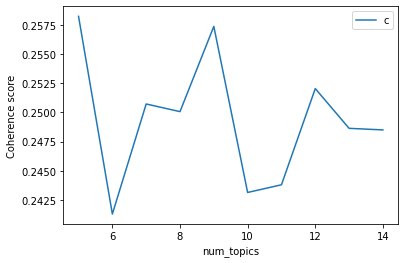

In [80]:
lmlist, c_v, n = evaluate_graph(dictionary=new_corpus_bow.diccionario,
                                corpus=new_corpus_bow,
                                texts=new_textos_lemas_trigramas,
                                limit=15, # q vaya de 5 a 15 con saltos de 2
                                start=5,
                                step=1)

De la gráfica podemos ver que el máximo viene en K=5, por lo que podría ser mayor aún para un K menor a 5. Además hay otro pico en 9. 
Vamos a probar entonces para K=5 y para K=9 a ver qué temáticas son más sencillas de interpretar.

## Probamos para K = 5
Recalculamos para K = 5 temáticas

In [115]:
# Crea corpus (BoW)
corpus = [new_corpus_bow.diccionario.doc2bow(text) for text in new_textos_lemas_trigramas]

# Aplica el modelo LDA
#ldamodel = LdaModel(corpus=corpus, num_topics=5, id2word=new_corpus_bow.diccionario)
ldamodel = LdaModel(corpus=corpus, num_topics=5, id2word=new_corpus_bow.diccionario, 
                    random_state=100,
                    update_every=1,
                    chunksize=100, 
                    passes=10,
                    alpha='auto')


# Representa gráficamente
vis_data = gensimvis.prepare(ldamodel, corpus, new_corpus_bow.diccionario)
pyLDAvis.display(vis_data)

Los temas 1 y 2 comparten bastantes términos, por lo que se deduce que son temáticas con alto grado de similitud viendo el área de intersección de ambas. El resto de temáticas están muy bien separadas. 

El hecho de que K = 5 obtuviera el mayor valor de coherencia y la forma de las temáticas 1 y 2 le da más fuerza a la asunción de que con K=4 podría haber auún mejor definición de las temáticas, al poder unirse las 1 y 2 de aquí en una misma, no se va a repetir el barrido bajando el inicio a un K < 4 pero se evidencia que se obtendría mayor valor de coherencia con K = 4. 

**Se probará a generar los resultados para K = 4 de todos modos**.

### Determinar el tema dominante en cada documento
Una aplicación práctica del topic modeling es determinar de qué tema trata un documento.  
Para hacer esto, se busca el número de tema que tiene una mayor contribución en el documento.  
La función `format_topics_sentences()` genera esta información en forma de tabla.  

In [116]:
def format_topics_sentences(ldamodel, corpus):
    # inicializa salida
    sent_topics_df = pd.DataFrame()

    # obtiene main topic de cada documento
    # al aplicar el LDA sobre el corpus, será el primero que aparezca en la lista de tuplas (el de mas peso)
    for row in ldamodel[corpus]:
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        (topic_num, prop_topic)=row[0]
        wp = ldamodel.show_topic(topic_num)
        topic_keywords = ", ".join([word for word, prop in wp])
        sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
    sent_topics_df.reset_index(inplace=True)
    sent_topics_df.columns = ['No_doc','Tema_dominante', 'Contribucion_per', 'Palabras_clave']
    sent_topics_df['Tema_dominante'] = sent_topics_df['Tema_dominante'].astype('int')
    return(sent_topics_df)

In [117]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=new_corpus_bow)

# Manera mas elegante de mostrar la informacion
df_topic_sents_keywords

,No_doc,Tema_dominante,Contribucion_per,Palabras_clave
0,0,4,0.5069,"mujer, joven, padre, hijo, familia, casa, pers..."
1,1,4,0.6903,"mujer, joven, padre, hijo, familia, casa, pers..."
2,2,4,0.4861,"mujer, joven, padre, hijo, familia, casa, pers..."
3,3,4,0.5367,"mujer, joven, padre, hijo, familia, casa, pers..."
4,4,4,0.4805,"mujer, joven, padre, hijo, familia, casa, pers..."
...,...,...,...,...
3873,3873,1,0.4285,"serie, terror, pantalla, resultado, monstruo, ..."
3874,3874,4,0.5374,"mujer, joven, padre, hijo, familia, casa, pers..."
3875,3875,4,0.3748,"mujer, joven, padre, hijo, familia, casa, pers..."
3876,3876,1,0.4869,"serie, terror, pantalla, resultado, monstruo, ..."


Una vez se tiene el dataframe de arriba se puede usar para varios análisis: por ejemplo para ver el documento que tiene un procentaje de contribución a su temática mayor, no seria el equivalente al centroide en un cluster exactamente pero sí el prototipo que mejor lo define al tema.


### Determinar el documento más representativo de cada tema
Agrupando por temas, podemos seleccionar el de mayor porcentaje como más representativo.

In [118]:
# Agrupamos documentos por tema
sent_topics_sorted = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Tema_dominante')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorted = pd.concat([sent_topics_sorted, 
                                    grp.sort_values(['Contribucion_per'], 
                                    ascending=[0]).head(1)], axis=0)

# Reset Index    
sent_topics_sorted.reset_index(drop=True, inplace=True)

# cambiamos nombre de columna
sent_topics_sorted.columns = df_topic_sents_keywords.columns

# Mostramos
sent_topics_sorted

,No_doc,Tema_dominante,Contribucion_per,Palabras_clave
0,266,0,0.6156,"comedia, novela, humor, libro, tal_vez, pantal..."
1,1006,1,0.8094,"serie, terror, pantalla, resultado, monstruo, ..."
2,558,2,0.5020,"policia, asesino, thriller, crimen, asesinato,..."
3,2439,3,0.7504,"imagen, relato, guerra, realidad, elemento, mi..."
4,681,4,0.7355,"mujer, joven, padre, hijo, familia, casa, pers..."


Podemos ver el documento más representativo por el No_doc, habría estado bien en el momento del procesado de ficheros haber guardado el título de la película para tener algo más de información (aunque podría haber varias críticas de la misma película, reslatando diferentes características en cada crítica y compartiendo otras). De todos modos esta modificación requeriría ejecutar todo de nuevo y eso requiere mucho tiempo adicional, por lo que se va a dejar así.

### Distribución de temas entre documentos
Por último, podemos analizar el volumen y la distribución de temas entre los documentos del tema.  

**Ver cómo se han separado los distintos docs entre los distintos temas**

In [119]:
# núm de documentos por cada tema
topic_counts = df_topic_sents_keywords['Tema_dominante'].value_counts()

# porcentaje de documentos por cada tema
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# palabras clave de cada tema
topic_num_keywords = sent_topics_sorted[['Tema_dominante', 'Palabras_clave']]

# Concatenamos por columna
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# cambiamos nombre de columna
df_dominant_topics.columns = ['Tema_dominante', 'Palabras_clave', 'Num_Documentos', 'Porcent_Documentos']

# Show
df_dominant_topics

,Tema_dominante,Palabras_clave,Num_Documentos,Porcent_Documentos
0,0,"comedia, novela, humor, libro, tal_vez, pantal...",416,0.1073
1,1,"serie, terror, pantalla, resultado, monstruo, ...",1578,0.4069
2,2,"policia, asesino, thriller, crimen, asesinato,...",54,0.0139
3,3,"imagen, relato, guerra, realidad, elemento, mi...",473,0.1220
4,4,"mujer, joven, padre, hijo, familia, casa, pers...",1357,0.3499


En este apartado final podemos ver tanto el número de documentos como su porcentaje relativo, aprovecharemos aquí para dar una interpretación de cada temática y su peso:
 - **Tema_dominante	 0:** Comedias, cine de humor, con un 11% de los documentos.
 - **Tema_dominante	 1:** Terror y fantástico: cine y series cinematográficas (recordemos que dentro de este género hay largas sagas...), con un 41% de los documentos.
 - **Tema_dominante	 2:** Género policíaco, thriller y de suspense, con un 1% de los documentos.
 - **Tema_dominante	 3:** Cine de autor, documental y social, con un 12% de los documentos.
 - **Tema_dominante	 5:** Dramas y romances, con un 35% de los documentos.


## Probamos para K = 9
Recalculamos para K = 9 temáticas

In [120]:
# Crea corpus (BoW)
corpus = [new_corpus_bow.diccionario.doc2bow(text) for text in new_textos_lemas_trigramas]

# Aplica el modelo LDA
#ldamodel = LdaModel(corpus=corpus, num_topics=9, id2word=new_corpus_bow.diccionario), random_state=100)
ldamodel = LdaModel(corpus=corpus, num_topics=9, id2word=new_corpus_bow.diccionario, 
                    random_state=100,
                    update_every=1,
                    chunksize=100, 
                    passes=10,
                    alpha='auto')

# Representa gráficamente
vis_data = gensimvis.prepare(ldamodel, corpus, new_corpus_bow.diccionario)
pyLDAvis.display(vis_data)

Aquí la división no es tan clara como para K = 5, por lo que preferimos esas temáticas sobre estas.
**No se analizarán en detalle, pero se generarán los resultados para compararlos a alto nivel sobre los anteriores.**

### Determinar el tema dominante en cada documento  

In [122]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=new_corpus_bow)

# Manera mas elegante de mostrar la informacion
df_topic_sents_keywords.head(10)

,No_doc,Tema_dominante,Contribucion_per,Palabras_clave
0,0,4,0.2632,"mujer, niño, padre, hijo, familia, joven, amor..."
1,1,4,0.3244,"mujer, niño, padre, hijo, familia, joven, amor..."
2,2,1,0.4028,"serie, producto, pantalla, resultado, trama, h..."
3,3,4,0.4098,"mujer, niño, padre, hijo, familia, joven, amor..."
4,4,0,0.2719,"comedia, humor, chica, gusto, pantalla, dialog..."
5,5,1,0.2071,"serie, producto, pantalla, resultado, trama, h..."
6,6,0,0.3142,"comedia, humor, chica, gusto, pantalla, dialog..."
7,7,1,0.4237,"serie, producto, pantalla, resultado, trama, h..."
8,8,7,0.4907,"filme, actriz, fotografia, epoca, interpretaci..."
9,9,6,0.1886,"guerra, grupo, policia, violencia, terror, cam..."


### Determinar el documento más representativo de cada tema

In [124]:
# Agrupamos documentos por tema
sent_topics_sorted = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Tema_dominante')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorted = pd.concat([sent_topics_sorted, 
                                    grp.sort_values(['Contribucion_per'], 
                                    ascending=[0]).head(1)], axis=0)

# Reset Index    
sent_topics_sorted.reset_index(drop=True, inplace=True)

# cambiamos nombre de columna
sent_topics_sorted.columns = df_topic_sents_keywords.columns

# Mostramos
sent_topics_sorted

,No_doc,Tema_dominante,Contribucion_per,Palabras_clave
0,2677,0,0.5717,"comedia, humor, chica, gusto, pantalla, dialog..."
1,1006,1,0.6692,"serie, producto, pantalla, resultado, trama, h..."
2,786,2,0.2482,"profesor, john_hurt, tommy_lee_jón, colaboraci..."
3,59,3,0.7290,"imagen, relato, mirada, elemento, idea, narrac..."
4,871,4,0.5252,"mujer, niño, padre, hijo, familia, joven, amor..."
5,383,5,0.2749,"leone, tim_burton, sonido, orfanato, sweeney_t..."
6,49,6,0.5192,"guerra, grupo, policia, violencia, terror, cam..."
7,95,7,0.5850,"filme, actriz, fotografia, epoca, interpretaci..."
8,13,8,0.3544,"novela, libro, western, escritor, laura, igles..."


### Distribución de temas entre documentos

In [125]:
# núm de documentos por cada tema
topic_counts = df_topic_sents_keywords['Tema_dominante'].value_counts()

# porcentaje de documentos por cada tema
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# palabras clave de cada tema
topic_num_keywords = sent_topics_sorted[['Tema_dominante', 'Palabras_clave']]

# Concatenamos por columna
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# cambiamos nombre de columna
df_dominant_topics.columns = ['Tema_dominante', 'Palabras_clave', 'Num_Documentos', 'Porcent_Documentos']

# Show
df_dominant_topics

,Tema_dominante,Palabras_clave,Num_Documentos,Porcent_Documentos
0,0,"comedia, humor, chica, gusto, pantalla, dialog...",950,0.2450
1,1,"serie, producto, pantalla, resultado, trama, h...",1204,0.3105
2,2,"profesor, john_hurt, tommy_lee_jón, colaboraci...",6,0.0015
3,3,"imagen, relato, mirada, elemento, idea, narrac...",291,0.0750
4,4,"mujer, niño, padre, hijo, familia, joven, amor...",622,0.1604
5,5,"leone, tim_burton, sonido, orfanato, sweeney_t...",22,0.0057
6,6,"guerra, grupo, policia, violencia, terror, cam...",342,0.0882
7,7,"filme, actriz, fotografia, epoca, interpretaci...",381,0.0982
8,8,"novela, libro, western, escritor, laura, igles...",60,0.0155


Como se puede ver en los resultados de cada sub-apartado, la división no es tan clara como para K = 5, por lo que preferimos esas temáticas sobre estas.

## Probamos para K = 4
Como ya se ha mencionado anteriormente, y para satisfacer la curiosidad, pese a ser un número de temáticas fuera del rango propuesto, vamos a ver cómo iría para 4 temáticas y **comprobar si nuestra intuición es correcta**.

Recalculamos para K = 4 temáticas

In [126]:
# Crea corpus (BoW)
corpus = [new_corpus_bow.diccionario.doc2bow(text) for text in new_textos_lemas_trigramas]

# Aplica el modelo LDA
#ldamodel = LdaModel(corpus=corpus, num_topics=4, id2word=new_corpus_bow.diccionario), random_state=100)
ldamodel = LdaModel(corpus=corpus, num_topics=4, id2word=new_corpus_bow.diccionario, 
                    random_state=100,
                    update_every=1,
                    chunksize=100, 
                    passes=10,
                    alpha='auto')

# Representa gráficamente
vis_data = gensimvis.prepare(ldamodel, corpus, new_corpus_bow.diccionario)
pyLDAvis.display(vis_data)

Efectivamente ahora tenemos 4 temáticas perfectamente bien definidas (disjuntas) y con gran separación entre ellas. En el último apartado veremos su interpretación.

### Determinar el tema dominante en cada documento
Una aplicación práctica del topic modeling es determinar de qué tema trata un documento.  
Para hacer esto, se busca el número de tema que tiene una mayor contribución en el documento.  
La función `format_topics_sentences()` genera esta información en forma de tabla.  

In [128]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=new_corpus_bow)

# Manera mas elegante de mostrar la informacion
df_topic_sents_keywords.head(10)

,No_doc,Tema_dominante,Contribucion_per,Palabras_clave
0,0,0,0.4938,"comedia, mujer, niño, casa, humor, amigo, jove..."
1,1,0,0.5819,"comedia, mujer, niño, casa, humor, amigo, jove..."
2,2,0,0.6079,"comedia, mujer, niño, casa, humor, amigo, jove..."
3,3,0,0.4145,"comedia, mujer, niño, casa, humor, amigo, jove..."
4,4,1,0.4457,"terror, serie, pantalla, resultado, monstruo, ..."
5,5,1,0.3950,"terror, serie, pantalla, resultado, monstruo, ..."
6,6,0,0.4247,"comedia, mujer, niño, casa, humor, amigo, jove..."
7,7,1,0.4676,"terror, serie, pantalla, resultado, monstruo, ..."
8,8,1,0.4524,"terror, serie, pantalla, resultado, monstruo, ..."
9,9,0,0.3448,"comedia, mujer, niño, casa, humor, amigo, jove..."


Una vez tengo el df de arriba lo puedo usar para varios análisis: por ejemplo para tema ver el doc que tiene un procentaje mayor, no seria el centroide en un cluster pero sí el prototipo que mejor lo define al tema.


### Determinar el documento más representativo de cada tema
Agrupando por temas, podemos seleccionar el de mayor porcentaje como más representativo.

In [130]:
# Agrupamos documentos por tema
sent_topics_sorted = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Tema_dominante')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorted = pd.concat([sent_topics_sorted, 
                                    grp.sort_values(['Contribucion_per'], 
                                    ascending=[0]).head(1)], axis=0)

# Reset Index    
sent_topics_sorted.reset_index(drop=True, inplace=True)

# cambiamos nombre de columna
sent_topics_sorted.columns = df_topic_sents_keywords.columns

# Mostramos
sent_topics_sorted

,No_doc,Tema_dominante,Contribucion_per,Palabras_clave
0,1440,0,0.8512,"comedia, mujer, niño, casa, humor, amigo, jove..."
1,3525,1,0.8347,"terror, serie, pantalla, resultado, monstruo, ..."
2,951,2,0.6261,"policia, asesino, leone, trama, thriller, negr..."
3,3617,3,0.9234,"imagen, realidad, relato, guerra, amor, elemen..."


### Distribución de temas entre documentos
Por último, podemos analizar el volumen y la distribución de temas entre los documentos del tema.  

**Ver cómo se han separado los distintos docs entre los distintos temas**

In [131]:
# núm de documentos por cada tema
topic_counts = df_topic_sents_keywords['Tema_dominante'].value_counts()

# porcentaje de documentos por cada tema
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# palabras clave de cada tema
topic_num_keywords = sent_topics_sorted[['Tema_dominante', 'Palabras_clave']]

# Concatenamos por columna
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# cambiamos nombre de columna
df_dominant_topics.columns = ['Tema_dominante', 'Palabras_clave', 'Num_Documentos', 'Porcent_Documentos']

# Show
df_dominant_topics

,Tema_dominante,Palabras_clave,Num_Documentos,Porcent_Documentos
0,0,"comedia, mujer, niño, casa, humor, amigo, jove...",1356,0.3497
1,1,"terror, serie, pantalla, resultado, monstruo, ...",1247,0.3216
2,2,"policia, asesino, leone, trama, thriller, negr...",226,0.0583
3,3,"imagen, realidad, relato, guerra, amor, elemen...",1049,0.2705


En este apartado final podemos ver tanto el número de documentos como su porcentaje relativo, aprovecharemos aquí para dar una interpretación de cada temática y su peso:
 - **Tema_dominante	 0:** Comedias, cine para toda la familia, ahora con un 35% de los documentos.
 - **Tema_dominante	 1:** Terror y fantástico: cine y series cinematográficas (recordemos que dentro de este género hay largas sagas...), ahora con un 32% de los documentos.
 - **Tema_dominante	 2:** Género policíaco, thriller y de suspense, ahora con un 6% de los documentos.
 - **Tema_dominante	 3:** Cine de autor, documental y social, ahora con un 27% de los documentos.


# Referencias:
    - Martin, F., & Johnson, M. (2015). More efficient topic modelling through a noun only approach. In B. Hachey, & K. Webster (Eds.), Proceedings of the Australasian Language Technology Association Workshop 2015 (pp. 111-115). (Australasian Language Technology Association workshop; Vol. 13). Australasian Language Technology Association. http://www.aclweb.org/anthology/U15-1013
    - Topic Modeling on Spanish Texts: https://medium.com/@armandj.olivares/topic-modeling-on-spanish-text-f7a5e998fb90